# Oxfort IIIT image segmentation with SwinUNET

In [1]:
import numpy as np
from glob import glob

import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, concatenate

In [3]:
import sys
sys.path.append('../')

from keras_vision_transformer import swin_layers
from keras_vision_transformer import transformer_layers
from keras_vision_transformer import utils

# Data and problem statement

This example applies the dataset of [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al. 2012). This dataset contains images of pets and their pixel-wise mask that indicates (1) pixels belonging to the pet, (2) pixels bordering the pet, and (3) surrounding pixels.

A semantic segmentation problem is proposed; it takes images as inputs and predicts the classification probability of the three pixel-wise masks.

In [4]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/system/drive/oxford_iiit/'

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)

# The Swin-UNET

Two functions are provided for customizing the Swin-UNET:
    
* `swin_transformer_stack`: a function that stacks multiple Swin Transformers.
* `swin_unet_2d_base`: the base architecture of the Swin-UNET with down-/upsampling levels and skip connections.

In [6]:
def swin_transformer_stack(X, stack_num, embed_dim, num_patch, num_heads, window_size, num_mlp, shift_window=True, name=''):
    '''
    Stacked Swin Transformers that share the same token size.
    
    Alternated Window-MSA and Swin-MSA will be configured if `shift_window=True`, Window-MSA only otherwise.
    *Dropout is turned off.
    '''
    # Turn-off dropouts
    mlp_drop_rate = 0 # Droupout after each MLP layer
    attn_drop_rate = 0 # Dropout after Swin-Attention
    proj_drop_rate = 0 # Dropout at the end of each Swin-Attention block, i.e., after linear projections
    drop_path_rate = 0 # Drop-path within skip-connections
    
    qkv_bias = True # Convert embedded patches to query, key, and values with a learnable additive value
    qk_scale = None # None: Re-scale query based on embed dimensions per attention head # Float for user specified scaling factor
    
    if shift_window:
        shift_size = window_size // 2
    else:
        shift_size = 0
    
    for i in range(stack_num):
    
        if i % 2 == 0:
            shift_size_temp = 0
        else:
            shift_size_temp = shift_size

        X = swin_layers.SwinTransformerBlock(dim=embed_dim, num_patch=num_patch, num_heads=num_heads, 
                                 window_size=window_size, shift_size=shift_size_temp, num_mlp=num_mlp, qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 mlp_drop=mlp_drop_rate, attn_drop=attn_drop_rate, proj_drop=proj_drop_rate, drop_path_prob=drop_path_rate, 
                                 name='name{}'.format(i))(X)
    return X


def swin_unet_2d_base(input_tensor, filter_num_begin, depth, stack_num_down, stack_num_up, 
                      patch_size, num_heads, window_size, num_mlp, shift_window=True, name='swin_unet'):
    '''
    The base of SwinUNET.
    '''
    # Compute number be patches to be embeded
    input_size = input_tensor.shape.as_list()[1:]
    num_patch_x = input_size[0]//patch_size[0]
    num_patch_y = input_size[1]//patch_size[1]
    
    # Number of Embedded dimensions
    embed_dim = filter_num_begin
    
    depth_ = depth
    
    X_skip = []

    X = input_tensor
    
    # Patch extraction
    X = transformer_layers.patch_extract(patch_size)(X)

    # Embed patches to tokens
    X = transformer_layers.patch_embedding(num_patch_x*num_patch_y, embed_dim)(X)
    
    # The first Swin Transformer stack
    X = swin_transformer_stack(X, stack_num=stack_num_down, 
                               embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                               num_heads=num_heads[0], window_size=window_size[0], num_mlp=num_mlp, 
                               shift_window=shift_window, name='{}_swin_down0'.format(name))
    X_skip.append(X)
    
    # Downsampling blocks
    for i in range(depth_-1):
        
        # Patch merging
        X = transformer_layers.patch_merging((num_patch_x, num_patch_y), embed_dim=embed_dim, name='down{}'.format(i))(X)
        
        # update token shape info
        embed_dim = embed_dim*2
        num_patch_x = num_patch_x//2
        num_patch_y = num_patch_y//2
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, stack_num=stack_num_down, 
                                   embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                                   num_heads=num_heads[i+1], window_size=window_size[i+1], num_mlp=num_mlp, 
                                   shift_window=shift_window, name='{}_swin_down{}'.format(name, i+1))
        
        # Store tensors for concat
        X_skip.append(X)
        
    # reverse indexing encoded tensors and hyperparams
    X_skip = X_skip[::-1]
    num_heads = num_heads[::-1]
    window_size = window_size[::-1]
    
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    
    depth_decode = len(X_decode)
    
    for i in range(depth_decode):
        
        # Patch expanding
        X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, upsample_rate=2, return_vector=True)(X)
        

        # update token shape info
        embed_dim = embed_dim//2
        num_patch_x = num_patch_x*2
        num_patch_y = num_patch_y*2
        
        # Concatenation and linear projection
        X = concatenate([X, X_decode[i]], axis=-1, name='{}_concat_{}'.format(name, i))
        X = Dense(embed_dim, use_bias=False, name='{}_concat_linear_proj_{}'.format(name, i))(X)
        
        # Swin Transformer stacks
        X = swin_transformer_stack(X, stack_num=stack_num_up, 
                           embed_dim=embed_dim, num_patch=(num_patch_x, num_patch_y), 
                           num_heads=num_heads[i], window_size=window_size[i], num_mlp=num_mlp, 
                           shift_window=shift_window, name='{}_swin_up{}'.format(name, i))
        
    # The last expanding layer; it produces full-size feature maps based on the patch size
    # !!! <--- "patch_size[0]" is used; it assumes patch_size = (size, size)
    X = transformer_layers.patch_expanding(num_patch=(num_patch_x, num_patch_y), 
                                               embed_dim=embed_dim, upsample_rate=patch_size[0], return_vector=False)(X)
    
    return X

## Hyperparameters

Hyperparameters of the Swin-UNET are listed as follows:

In [7]:
filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2         # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 2-by-2 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True          # Apply window shifting, i.e., Swin-MSA

## Model configuration

In [8]:
# Input section
input_size = (128, 128, 3)
IN = Input(input_size)

# Base architecture
X = swin_unet_2d_base(IN, filter_num_begin, depth, stack_num_down, stack_num_up, 
                  patch_size, num_heads, window_size, num_mlp, shift_window=shift_window, name='swin_unet')

In [10]:
# Output section
n_labels = 3
OUT = Conv2D(n_labels, kernel_size=1, use_bias=False, activation='softmax')(X)

# Model configuration
model = Model(inputs=[IN,], outputs=[OUT,])

In [13]:
# The optimizer
opt = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt)

## Data pre-processing

The input of RGB images are resized to 128-by-128 through the nearest neighbour scheme, and then normalized to the interval of [0, 1]. The training target of pixel-wise masks are resized similarly.

A random split is applied with 80%, 10%, 10% of the samples are assigned for training, validation, and testing, respectively.

In [14]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

In [15]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 5881:735:736


In [16]:
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))

In [17]:
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))
test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))

## Training

The segmentation model is trained with fixed 15 epoches. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [18]:
N_epoch = 15 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):
    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_target,])
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

	Initial loss = 2.7271347045898438
Validation performance is improved from 2.7271347045898438 to 0.7579582929611206
Validation performance is improved from 0.7579582929611206 to 0.7046754360198975
Validation performance is improved from 0.7046754360198975 to 0.6345415711402893
Validation performance is improved from 0.6345415711402893 to 0.5998015999794006
Validation performance is improved from 0.5998015999794006 to 0.5639835596084595
Validation performance 0.5655277967453003 is NOT improved
Validation performance is improved from 0.5639835596084595 to 0.5271018743515015
Validation performance is improved from 0.5271018743515015 to 0.5035313963890076
Validation performance is improved from 0.5035313963890076 to 0.49777665734291077
Validation performance is improved from 0.49777665734291077 to 0.4959720969200134
Validation performance is improved from 0.4959720969200134 to 0.4838007390499115
Validation performance 0.48960015177726746 is NOT improved
Validation performance is improved f

## Evaluation

The testing set performance is evaluated.

In [19]:
y_pred = model.predict([test_input,])
print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target, y_pred))))

Testing set cross-entropy loss = 0.5176490545272827


**Example of outputs**

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=False)
    return ax

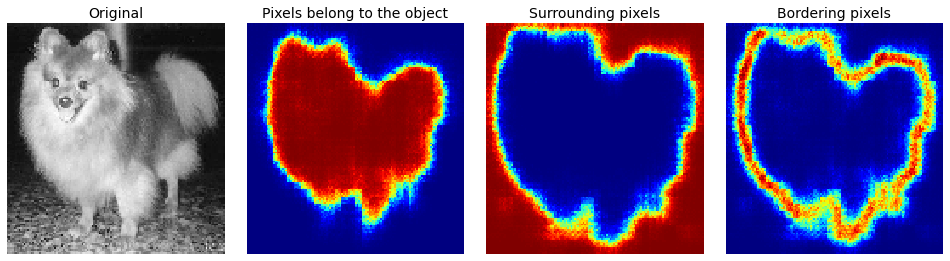

In [22]:
i_sample = 2

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
AX[3].pcolormesh(y_pred[i_sample, ..., 2], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);
AX[3].set_title("Bordering pixels", fontsize=14);

**References**

Cao, H., Wang, Y., Chen, J., Jiang, D., Zhang, X., Tian, Q. and Wang, M., 2021. Swin-Unet: Unet-like Pure Transformer for Medical Image Segmentation. arXiv preprint arXiv:2105.05537. https://arxiv.org/abs/2105.05537

Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., Lin, S. and Guo, B., 2021. Swin transformer: Hierarchical vision transformer using shifted windows. arXiv preprint arXiv:2103.14030. https://arxiv.org/abs/2103.14030